# Packages

In [35]:
#!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly

# Yahoo Finance OHLC DataFrame

In [36]:
stock = 'SPY'
df= yf.download(stock, '2020-10-31', '2022-10-31') 


[*********************100%***********************]  1 of 1 completed


In [37]:
df.reset_index( inplace = True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02 00:00:00-05:00,330.200012,332.359985,327.239990,330.200012,320.759491,86068300
1,2020-11-03 00:00:00-05:00,333.690002,338.250000,330.290009,336.029999,326.422821,93294200
2,2020-11-04 00:00:00-05:00,340.859985,347.940002,339.589996,343.540009,333.718079,126959700
3,2020-11-05 00:00:00-05:00,349.239990,352.190002,348.859985,350.239990,340.226501,82039700
4,2020-11-06 00:00:00-05:00,349.929993,351.510010,347.649994,350.160004,340.148804,74973000


# Support/Resistance Detection

In [38]:
def support(df, index, n1, n2):
    # n1 (n2) candle before (after) the index candle resp.
    # a function to test whether the index candle is support or not
    for i in range(index - n1 + 1, index + 1):
        if( df['Low'][i] > df['Low'][i-1]):
            return False
    for i in range(index+1, index + n2 + 1):
        if( df['Low'][i] < df['Low'][i-1] ):
            return False
    
    return True

In [39]:
def resistance(df, index, n1, n2):
    # a function to test whether the index candle is resistance or not
    
    for i in range(index-n1+1, index+1):
        if(df['High'][i] < df['High'][i-1]):
            return False
    for i in range(index + 1, index + n2 + 1):
        if(df['High'][i] > df['High'][i-1]):
            return False
    
    return True


In [40]:
# using two list support_list, resistance_list

support_list = []
resistance_list = []

n1 = 2
n2 = 2

for row in range(n1, len(df) - n2):
    if support(df, row, n1, n2 ):
        support_list.append((row , df['Low'][row], 0))

    if resistance(df , row, n1, n2):
        resistance_list.append((row, df['High'][row],1))

print(support_list)
#print(len(support_list))
print(resistance_list)
#print(len(resistance_list))

[(28, 363.260009765625, 0), (34, 362.0299987792969, 0), (42, 364.82000732421875, 0), (79, 378.2300109863281, 0), (83, 371.8800048828125, 0), (98, 383.8999938964844, 0), (131, 404.0, 0), (136, 405.3299865722656, 0), (157, 414.70001220703125, 0), (177, 421.9700012207031, 0), (188, 436.1000061035156, 0), (200, 436.1199951171875, 0), (217, 443.2200012207031, 0), (221, 428.8599853515625, 0), (238, 431.5400085449219, 0), (258, 462.0400085449219, 0), (281, 460.25, 0), (285, 451.1400146484375, 0), (299, 456.6000061035156, 0), (308, 420.760009765625, 0), (330, 410.6400146484375, 0), (342, 415.7900085449219, 0), (359, 443.4700012207031, 0), (366, 435.6099853515625, 0), (376, 405.0199890136719, 0), (384, 385.1499938964844, 0), (426, 371.0400085449219, 0), (481, 357.0400085449219, 0), (496, 363.5400085449219, 0)]
[(10, 362.7799987792969, 1), (26, 371.04998779296875, 1), (46, 381.489990234375, 1), (71, 394.1700134277344, 1), (92, 398.1199951171875, 1), (113, 417.9100036621094, 1), (118, 418.25, 1),

In [41]:
support_list.sort()
resistance_list.sort()

# merge lines that are close to each other
for i in range(1 , len(support_list)):
    if ( i >= len(support_list)):
        break
    if abs( support_list[i][1] - support_list[i-1][1] <= 1):
        support_list.pop(i)

for i in range(1, len(resistance_list)):
    if( i >= len(resistance_list)):
        break
    if abs( resistance_list[i][1] - resistance_list[i-1][1] <= 1):
        resistance_list.pop(i)
        
        
pivotlist = support_list + resistance_list

pivotlist.sort()
print(len(support_list))
#print(support_list)
print(len(resistance_list))
#print(resistance_list)
print(len(pivotlist))
#print(pivotlist)

20
22
42


In [32]:
PriceSignal = [0] *len(df)

#start = pivotlist[0][0] + 1
for row in range(0 , len(df)):

    for pivot in pivotlist:
        # the date of current candle is on or before the pivotlist
        if ( row <= pivot[0]):
            break
        # 0 indicates support level
        if ( pivot[2] == 0 ): 
            # support level check if it undercuts and rallies
            if (df["Low"][row] <= pivot[1] and df["Close"][row] > pivot[1]):
                PriceSignal[row] = 1 # indicate it undercuts and rallies above support
        # 1 indicates resistance level
        elif ( pivot[2] == 1):
            # resistance level check if it rallies above the level and reverse below it
            if ( df["High"][row] >= pivot[1] and df["Close"][row] < pivot[1]):
                PriceSignal[row] = 2

df["PriceSignal"] = PriceSignal

# Visualizing signals on chart

In [33]:
def SupportPos(x):
    if (x["PriceSignal"] == 1):
        return x["Low"] - 2e-3
    else:
        return np.nan

def ResistPos(x):
    if ( x["PriceSignal"] == 2):
        return x["High"] + 2e-3
    else:
        return np.nan

df["SupportPos"] = df.apply( lambda row: SupportPos(row), axis = 1)

df["ResistPos"] =  df.apply( lambda row: ResistPos(row), axis = 1)

In [34]:
fig = plotly.subplots.make_subplots( rows = 2, cols = 1, shared_xaxes = True,
                    vertical_spacing= 0.03, row_width = [0.2, 0.7])

fig.add_trace(go.Candlestick(x = df.index,
                            open = df['Open'],
                            high = df['High'], 
                            low = df['Low'], 
                            close = df['Close']),
                            row = 1 , col = 1) 


fig.add_trace(go.Bar(x =df["Date"] , y = df['Volume'], showlegend = False ), 
                     row = 2, col =1)

fig.update(layout_xaxis_rangeslider_visible=False)

counter1 = 0
counter2 = 0

while(True):
    if (counter1 > len(support_list) - 1):
        break
    fig.add_shape( type = 'line', line=dict(color="Green",width=1) ,x0 = support_list[counter1][0]-3 , y0 = support_list[counter1][1],
                  x1 = df.shape[0], y1 = support_list[counter1][1])
    
    counter1 += 1

while(True):
    if (counter2 > len(resistance_list) - 1):
        break
  
    fig.add_shape( type = 'line', line=dict(color="Red",width=1),x0 = resistance_list[counter2][0] - 3 , y0 = resistance_list[counter2][1], 
                x1 = df.shape[0], y1 = resistance_list[counter2][1])
    counter2 +=1


fig.add_scatter(x = df.index , y = df['SupportPos'] ,mode = "markers",
                marker = dict(size = 8 , color = "MediumPurple"), name = "Support_Signal")

fig.add_scatter(x = df.index , y = df['ResistPos'] ,mode = "markers",
                marker = dict(size = 8 , color = "MediumBlue"), name = "Resistance_Signal")
fig.update_layout(title = f"{stock} daily chart ")
fig.show()



NameError: name 'plotly' is not defined

In [ ]:
# make a most simple strategy: long 1 share at the next open when crossover support,
#                              Short 1 share at the next open when crossover resistance.

pd.options.mode.chained_assignment = None

df_rtn = df.copy()

df_rtn.loc[0,"netvalue"] = 1  

for i in range(0,len(df_rtn)-1):
    if (df_rtn['PriceSignal'][i] == 2):
    
        #rt.append(max((partial_book['KF_MID'][i]-partial_book['ASK_PRICE_1'][i])/partial_book['ASK_PRICE_1'][i],0))
        df_rtn.loc[i+1, "return"] = ( - ( (df["Open"][i+1]) - (df["Close"][i+1]))/(df["Close"][i+1]) ) #short at open
        #times.append( (df["Date"][i+1]) )
        df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i] * (1+df_rtn["return"][i+1])
    elif (df_rtn['PriceSignal'][i] == 1):
        df_rtn.loc[i+1, "return"] =(   ( (df["Open"][i+1]) - (df["Close"][i+1]))/(df["Close"][i+1]) ) #long at open
        
        df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i] * (1+df_rtn["return"][i+1])
        #times.append( (df["Date"][i+1]) )
    else:
        
        df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i]
    


In [ ]:
df_rtn

In [ ]:
fig =go.Figure()
fig.add_trace(go.Scatter(x = df_rtn['Date'] , y = df_rtn['netvalue'] ,mode = "lines",
                         marker = dict(size = 8 , color = "Black"), name = "Net Value"))
fig.show()

# Exponential Weighting Price Level Based on Volume and Time

## Reset DataFrame

In [11]:
stock = 'SPY'
df= yf.download(stock, '2020-10-31', '2022-10-31') 
df.reset_index( inplace = True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02 00:00:00-05:00,330.200012,332.359985,327.239990,330.200012,320.759491,86068300
1,2020-11-03 00:00:00-05:00,333.690002,338.250000,330.290009,336.029999,326.422791,93294200
2,2020-11-04 00:00:00-05:00,340.859985,347.940002,339.589996,343.540009,333.718140,126959700
3,2020-11-05 00:00:00-05:00,349.239990,352.190002,348.859985,350.239990,340.226532,82039700
4,2020-11-06 00:00:00-05:00,349.929993,351.510010,347.649994,350.160004,340.148804,74973000


In [12]:
# using two list support_list, resistance_list
support_list = []
resistance_list = []

n1 = 2
n2 = 2

for row in range(n1, len(df) - n2):
    if support(df, row, n1, n2 ):
        support_list.append((row , df['Low'][row], 0))

    if resistance(df , row, n1, n2):
        resistance_list.append((row, df['High'][row],1))

In [13]:

# using two list support_list, resistance_list

support_list = []
resistance_list = []
# add a volume and  time weighing
volsums=0
volsumr=0
vollists=[]
vollistr=[]
timelists=[]
timelistr=[]


n1 = 2
n2 = 2

for row in range(n1, len(df) - n2):
    if support(df, row, n1, n2 ):
        support_list.append([row , df['Low'][row], 0, df['Volume'][row], df['Date'][row]])
        volsums+=df['Volume'][row]
        timelists.append(df['Date'][row])
        vollists.append(df['Volume'][row])
    if resistance(df , row, n1, n2):
        resistance_list.append([row, df['High'][row],1, df['Volume'][row], df['Date'][row]])
        volsumr+=df['Volume'][row]
        timelistr.append(df['Date'][row])
        vollistr.append(df['Volume'][row])
# print(support_list)
# print(len(support_list))
# print(resistance_list)
# print(len(resistance_list))
# print(volsums)
# print(volsumr)
# vollists
# vollistr
# timelists
# timelistr

In [14]:
support_list.sort()
resistance_list.sort()

# merge lines that are close to each other
for i in range(1 , len(support_list)):
    if ( i >= len(support_list)):
        break
    if abs( support_list[i][1] - support_list[i-1][1] <= 1):
        support_list.pop(i)

for i in range(1, len(resistance_list)):
    if( i >= len(resistance_list)):
        break
    if abs( resistance_list[i][1] - resistance_list[i-1][1] <= 1):
        resistance_list.pop(i)

print(len(support_list))

print(len(resistance_list))

20
22


In [15]:
# support weights
vollists=vollists/sum(vollists)
volws=[]
timews=[]
target=vollists
target=pd.Series(target)
ttt=pd.to_datetime(timelists)

# a=target.ewm(alpha=0.95).mean()

for i in range(len(support_list)):
    vw=0.95*(i)*0.05/(1-0.95**(len(support_list)))*vollists[i]
    volws.append(vw)
volws=volws/max(volws)
volws

array([0.        , 0.02014817, 0.04607577, 0.09575981, 0.15337547,
       0.12137455, 0.16908108, 0.15578725, 0.19845974, 0.2784098 ,
       0.12135281, 0.2134107 , 0.19615091, 0.45230757, 0.2135574 ,
       0.21769828, 0.32530519, 0.38071319, 0.44911446, 1.        ])

## Adding Stop Loss Feature

<AxesSubplot:ylabel='Frequency'>

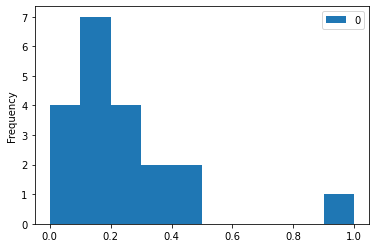

In [16]:
qt=pd.DataFrame(volws)
qt.plot.hist()

In [17]:
cutoffs1=qt.quantile(1/3)
cutoffs2=qt.quantile(2/3)

In [18]:
stoplosss=[]
for i in range(len(volws)):
    if volws[i]<=cutoffs1[0]:
        stoplosss.append(0.995)
    elif volws[i]<=cutoffs2[0]:
        stoplosss.append(0.99)
    else:
        stoplosss.append(0.98)

In [19]:
# resistance weights
vollistr=vollistr/sum(vollistr)
volwr=[]
timewr=[]
target=vollistr
target=pd.Series(target)
ttt=pd.to_datetime(timelistr)
# a=target.ewm(halflife='30 days', times=ttt).mean()

# a=target.ewm(alpha=0.95).mean()

for i in range(len(resistance_list)):
    vw=0.95*i*0.05/(1-0.95**(len(resistance_list)))*vollistr[i]
    volwr.append(vw)
volwr=volwr/max(volwr)
volwr

array([0.        , 0.03511711, 0.06793938, 0.07247144, 0.18570184,
       0.19439805, 0.20817447, 0.22470567, 0.20555726, 0.21970096,
       0.34947304, 0.22156562, 0.43447262, 0.40903502, 0.77342849,
       0.50600156, 0.51263932, 0.94554732, 0.78985372, 0.76416228,
       1.        , 0.86169773])

<AxesSubplot:ylabel='Frequency'>

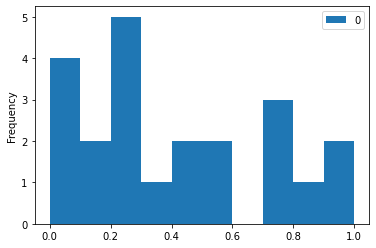

In [20]:
qtr=pd.DataFrame(volwr)
qtr.plot.hist()

In [21]:
cutoffr1=qtr.quantile(1/3)
cutoffr2=qtr.quantile(2/3)

In [22]:
stoplossr=[]
for i in range(len(volwr)):
    if volwr[i]<=cutoffr1[0]:
        stoplossr.append(0.995)
    elif volwr[i]<=cutoffr2[0]:
        stoplossr.append(0.99)
    else:
        stoplossr.append(0.98)
        

for i in range(len(support_list)):
      support_list[i].append(stoplosss[i])
for i in range(len(resistance_list)):
      resistance_list[i].append(stoplossr[i])

pivotlist = support_list + resistance_list

pivotlist.sort()

In [23]:
PriceSignal = [0] *len(df)
Stoploss=[0]*len(df)
#start = pivotlist[0][0] + 1
for row in range(0 , len(df)):

    for pivot in pivotlist:
        # the date ofcurrent candle is on or before the pivotlist
        if ( row <= pivot[0]):
            break
        # 0 indicates support level
        if ( pivot[2] == 0 ): 
            # support level check if undercut and rally
            if (df["Low"][row] <= pivot[1] and df["Close"][row] > pivot[1]):
                PriceSignal[row] = 1 # indicate it's undercut and rally
                Stoploss[row]=pivot[-1]
        # 1 indicates resistance level
        elif ( pivot[2] == 1):
            # resistance level check if it rallies above the level and reverse
            if ( df["High"][row] >= pivot[1] and df["Close"][row] < pivot[1]):
                PriceSignal[row] = 2
                Stoploss[row]=pivot[-1]
df["PriceSignal"] = PriceSignal
df['StopLoss']=Stoploss


In [24]:
# make a most simple strategy: long 1 share at the next open when crossover support,
#                              Short 1 share at the next open when crossover resistance.

# stop loss, in agressive=0.5%, normal=1%, aggressive=2%

df_rtn = df.copy()

df_rtn.loc[0,"netvalue"] = 1  

for i in range(0,len(df_rtn)-1):
    if (df_rtn['PriceSignal'][i] == 2):
        #rt.append(max((partial_book['KF_MID'][i]-partial_book['ASK_PRICE_1'][i])/partial_book['ASK_PRICE_1'][i],0))
        if (df_rtn['Open'][i+1]*df_rtn['StopLoss'][i])<=df_rtn['Close'][i]:
              df_rtn.loc[i+1, "return"] = ( - ( (df["Open"][i+1]) - (df["Close"][i]))/(df["Close"][i]) ) #short at open
          #times.append( (df["Date"][i+1]) )
              df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i] * (1+df_rtn["return"][i+1])
        else:
              df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i]
    elif (df_rtn['PriceSignal'][i] == 1):
        if (df_rtn['Open'][i+1]*df_rtn['StopLoss'][i])>=df_rtn['Close'][i]:
              df_rtn.loc[i+1, "return"] =( ( (df["Open"][i+1]) - (df["Close"][i]))/(df["Close"][i]) )#long at open
          
              df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i] * (1+df_rtn["return"][i+1])
          #times.append( (df["Date"][i+1]) )
        else:
              df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i]
    else:
        
        df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i]
    


/var/folders/gs/bl32mqf12ljbnr95r03h17bc0000gp/T/ipykernel_22675/3278861985.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i]
/var/folders/gs/bl32mqf12ljbnr95r03h17bc0000gp/T/ipykernel_22675/3278861985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rtn["netvalue"][i+1] = df_rtn["netvalue"][i] * (1+df_rtn["return"][i+1])
/var/folders/gs/bl32mqf12ljbnr95r03h17bc0000gp/T/ipykernel_22675/3278861985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

## Visualize Net Value After Adding Stop Loss and Exponential Weighting

In [311]:
fig =go.Figure()
fig.add_trace(go.Scatter(x = df_rtn['Date'] , y = df_rtn['netvalue'] ,mode = "lines",
                         marker = dict(size = 8 , color = "Black"), name = "Net Value"))
fig.show()